In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import re
DATA_PATH = '../../OneDrive - m.titech.ac.jp/Lab/data'

In [4]:
def images_to_matrix(folder_path, convert_gray=False, is_binary=False, disp_used=False, seed=0, ratio=1.0):
    files = os.listdir(folder_path)
    files.sort(key=lambda f: int(re.search('hadamard_(\d+).png', f).group(1)))

    if seed != 0:
        random.seed(seed)
        random.shuffle(files)

    total_files = len(files)
    number_of_files_to_load = int(total_files * ratio)

    selected_files = files[:number_of_files_to_load]
    selected_files.sort(key=lambda f: int(re.search('hadamard_(\d+).png', f).group(1)))

    images = []
    use_list = []

    for file in selected_files:
        index = int(re.sub(r'\D', '', file))
        use_list.append(index)
        img = Image.open(os.path.join(folder_path, file))
        if convert_gray:
            img = img.convert('L')
        if is_binary:
            img = img.point(lambda x: 255 if x else 0, 'L')
        img_array = np.asarray(img).flatten()
        img_array = img_array / 255
        images.append(img_array)

    # diff = list(set(range(1, len(files)+1))-set(use_list))
    # print("Didn't use:", sorted(diff))
    if disp_used:
        print("Used:", use_list)

    return np.column_stack(images)


def max_eigenvalue(A):
    eigenvalues, eigenvectors = np.linalg.eig(A)
    return np.max(eigenvalues)


def fista(G, F, prox, lmd, threshold):
    L = max_eigenvalue(F.T @ F) *3
    print('L: {}'.format(L))
    gamma = 1 / L
    i = 1
    t = 1
    H_1_prev = np.zeros((G.shape[0], F.shape[0]))
    H_2_prev = np.zeros((G.shape[0], F.shape[0]))

    while True:
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        grad = - 2 * (G - H_2_prev @ F) @ F.T
        H_1 = prox(H_2_prev - (1 / L) * grad, gamma * lmd)
        H_2 = H_1 + (t - 1) / t_new * (H_1 - H_1_prev)

        error = np.linalg.norm(H_2 - H_2_prev, 'fro')
        print('iter: {}, error: {}'.format(i, error))
        if error < threshold:
            break

        t = t_new.copy()
        H_1_prev = H_1.copy()
        H_2_prev = H_2.copy()
        i += 1

    return H_2


# soft thresh
def prox_l1(V, lambda1):
    return np.sign(V) * np.maximum(np.abs(V) - lambda1, 0)


def prox_l12(Z, lambda_L):
    """ Proximal operator for the l12 norm """
    norm_Z = np.linalg.norm(Z, axis=1, keepdims=True)
    factor = np.maximum(0, 1 - lambda_L / norm_Z)
    return Z * factor


def prox_l122(Y, gamma):
    N = Y.shape[1]
    l1_norms = np.sum(np.abs(Y), axis=1)
    factor = (2 * gamma) / (1 + 2 * gamma * N)
    X = np.zeros_like(Y)

    # for s in range(Y.shape[0]):
    #     for t in range(Y.shape[1]):
    #         X[s, t] = np.sign(Y[s, t]) * np.maximum(np.abs(Y[s, t]) - factor * l1_norms[s], 0)
    X = np.sign(Y) * np.maximum(np.abs(Y) - factor * l1_norms[:, np.newaxis], 0)
    return X


def primal_dual(G, F, lambda1, lambda2, tau, sigma, max_iter):
    m, n = G.shape[0], F.shape[0]
    H = np.zeros((m, n))
    Y = np.zeros_like(G)

    for k in range(max_iter):
        H_prev = H.copy()
        gradient = (H @ F - G) @ F.T
        H = prox_l1(H - tau * gradient, tau * lambda1)

        Y = prox_l12(Y + sigma * ((H - H_prev) @ F), sigma * lambda2)

    return H

In [5]:
# パラメータ設定
n = 64
m = 128
seed = 2
ratio = 0.1

In [6]:
G_full = images_to_matrix(f"{DATA_PATH}/hadamard{n}_cap_R_230516_128/", convert_gray=True)
print(G_full.shape)

(16384, 4096)


In [7]:
G = images_to_matrix(f"{DATA_PATH}/hadamard{n}_cap_R_230516_128/", convert_gray=True, seed=seed, ratio=ratio)
F = images_to_matrix(f"{DATA_PATH}/Hadamard{n}_input/", convert_gray=True, disp_used=True, seed=seed, ratio=ratio)
print(G.shape)
print(F.shape)

Used: [17, 32, 38, 62, 63, 68, 70, 78, 83, 85, 89, 91, 117, 120, 124, 150, 170, 173, 181, 191, 205, 207, 209, 213, 216, 239, 249, 250, 268, 293, 322, 323, 332, 338, 349, 357, 358, 363, 372, 405, 406, 421, 442, 451, 466, 483, 503, 516, 520, 534, 562, 570, 579, 582, 616, 623, 632, 645, 650, 653, 671, 675, 678, 683, 688, 706, 723, 728, 729, 730, 735, 736, 739, 774, 775, 776, 798, 800, 805, 833, 857, 872, 874, 894, 915, 952, 958, 963, 998, 1001, 1002, 1005, 1012, 1017, 1035, 1041, 1044, 1051, 1060, 1069, 1088, 1092, 1097, 1105, 1106, 1108, 1112, 1132, 1148, 1151, 1161, 1170, 1171, 1178, 1201, 1218, 1229, 1235, 1238, 1244, 1256, 1270, 1292, 1295, 1300, 1321, 1323, 1331, 1341, 1346, 1354, 1362, 1375, 1388, 1389, 1406, 1418, 1419, 1420, 1448, 1464, 1484, 1501, 1503, 1507, 1512, 1521, 1550, 1561, 1571, 1575, 1589, 1591, 1615, 1623, 1625, 1628, 1639, 1658, 1681, 1688, 1695, 1700, 1705, 1711, 1727, 1743, 1753, 1754, 1781, 1782, 1785, 1799, 1801, 1807, 1809, 1819, 1839, 1840, 1853, 1857, 1877, 18

In [8]:
H1 = np.zeros((m**2, 1))
G1s = []
for _ in range(F.shape[1]):
    G1s.append(G_full[:, 0])
H1 = np.column_stack(G1s)
F_hat = 2 * F - 1
G_hat = 2 * G - H1
print(F_hat.shape)
print(G_hat.shape)

(4096, 409)
(16384, 409)


In [9]:
lmd = 1
threshold = 1e-2
DIRECTORY = DATA_PATH + '/240618'

In [10]:
H = fista(G_hat, F_hat, prox_l122, lmd, threshold)

L: 12288.0
iter: 1, error: 1.516864732357133
iter: 2, error: 0.7062653373358571
iter: 3, error: 0.3464433905833251
iter: 4, error: 0.2989629678105783
iter: 5, error: 0.30030767796134206
iter: 6, error: 0.3004285627455329
iter: 7, error: 0.3002501067709149
iter: 8, error: 0.29966166122889487
iter: 9, error: 0.2987468258018403
iter: 10, error: 0.2976008577314207
iter: 11, error: 0.2962939502415687
iter: 12, error: 0.2949322033253583
iter: 13, error: 0.29369586410707255
iter: 14, error: 0.2927828039857613
iter: 15, error: 0.2923230951616356
iter: 16, error: 0.29234743854737677
iter: 17, error: 0.29267657441733586
iter: 18, error: 0.2931573888088298
iter: 19, error: 0.29357008646102273
iter: 20, error: 0.2936991537041981
iter: 21, error: 0.2933635487612721
iter: 22, error: 0.2923919137951364
iter: 23, error: 0.29063925808598995
iter: 24, error: 0.28793110753016693
iter: 25, error: 0.2841602363401804
iter: 26, error: 0.27920691813094217
iter: 27, error: 0.2730649017220413
iter: 28, error: 0

In [11]:
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
if not os.path.exists(DIRECTORY + '/systemMatrix'):
    os.makedirs(DIRECTORY + '/systemMatrix')
SETTING=f"l1_p-{int(100*ratio)}_lmd-{int(lmd)}"
np.save(f"{DIRECTORY}/systemMatrix/H_matrix_hadamard_{SETTING}.npy", H)

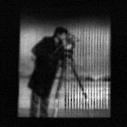

In [12]:
sample_image = Image.open(f"{DATA_PATH}/sample_image64/Cameraman64.png")
sample_image = sample_image.convert('L')
sample_image = np.asarray(sample_image).flatten() / 255

Hf = H @ sample_image
Hf_img = Hf.reshape(m, m)
# 0未満を0に、1以上を1に
Hf_img = np.clip(Hf_img, 0, 1)
Hf_pil = Image.fromarray((Hf_img * 255).astype(np.uint8), mode='L')

FILENAME = f"Cameraman64_{SETTING}.png"
fig, ax = plt.subplots(figsize=Hf_img.shape[::-1], dpi=1, tight_layout=True)
ax.imshow(Hf_pil, cmap='gray')
ax.axis('off')
fig.savefig(f"{DIRECTORY}/{FILENAME}", dpi=1)
plt.show()

# plt.figure(figsize=(10, 8))
# sns.heatmap(Hf_img, annot=False, cmap='viridis')

In [15]:
# ratio = 0.1
lmd = 10000000
H_true = np.load(f"{DATA_PATH}/systemMatrix/H_matrix_true.npy")
H = np.load(f"{DIRECTORY}/systemMatrix/H_matrix_l122_FISTA_hadamard_p-{int(100*ratio)}_lmd-{int(lmd)}.npy")
# l12 = np.linalg.norm(H_true, axis=1, ord=2)
# l1 = np.linalg.norm(H_true, ord=1)

# print(np.sum(l12))
# print(l1)

In [ ]:
plt.figure(figsize=(8, 10))
sns.heatmap(H_true, annot=False, cmap='viridis')

In [ ]:
Hl1 = np.load(f"{DATA_PATH}/240519/systemMatrix/H_matrix_FISTA_hadamard_p-10_lmd-1.npy")
# l12=np.linalg.norm(Hl1, axis=1, ord=2)
# l1=np.linalg.norm(Hl1, ord=1)
# print(np.sum(l12))
# print(l1)

<Axes: >

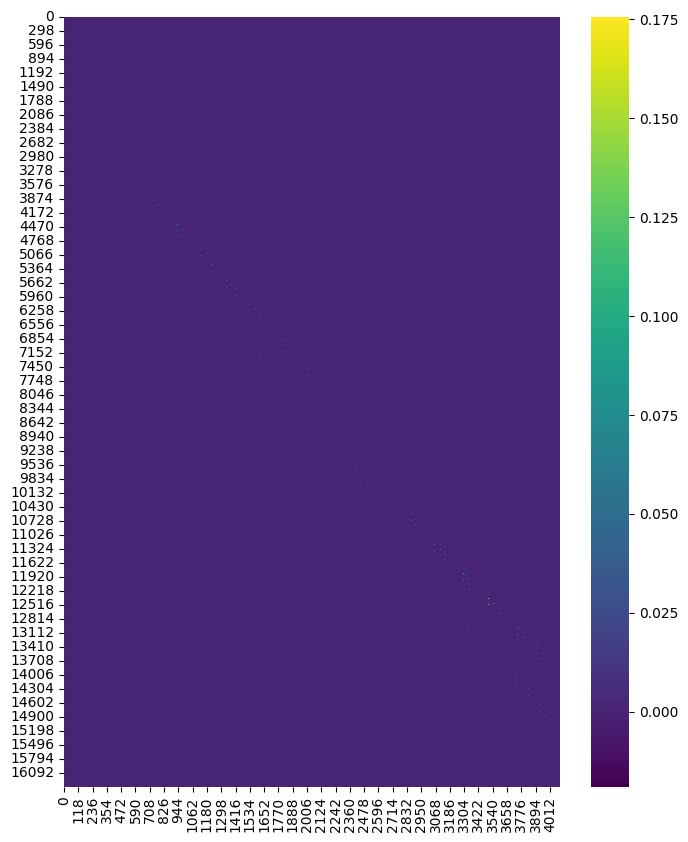

In [17]:
plt.figure(figsize=(8, 10))
sns.heatmap(H, annot=False, cmap='viridis')

In [16]:
rem = np.linalg.norm(H_true-H, 'fro')
print(rem)

1.8704371720346065


In [ ]:
def calc_nuclear_norm(matrix):
    """
    Calculate the nuclear norm (trace norm) of a given matrix.
    
    Parameters:
    matrix (numpy.ndarray): The input matrix.
    
    Returns:
    float: The nuclear norm of the matrix.
    """
    # Calculate the singular values of the matrix
    singular_values = np.linalg.svd(matrix, compute_uv=False)
    
    # Calculate the nuclear norm as the sum of singular values
    nuclear_norm = np.sum(singular_values)
    
    return nuclear_norm

In [ ]:
nnorm_true = calc_nuclear_norm(H_true)
nnorm_l1 = calc_nuclear_norm(Hl1)
print(nnorm_true)
print(nnorm_l1)